# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import random  
import cv2                
import matplotlib.pyplot as plt
import seaborn as sns                      
%matplotlib inline 


# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


**Analyzing and visualizing the "targets"**

In [2]:
# Get an basic idea of the Datasets by printing their shapes
train_targets.shape, valid_targets.shape, test_targets.shape

((6680, 133), (835, 133), (836, 133))

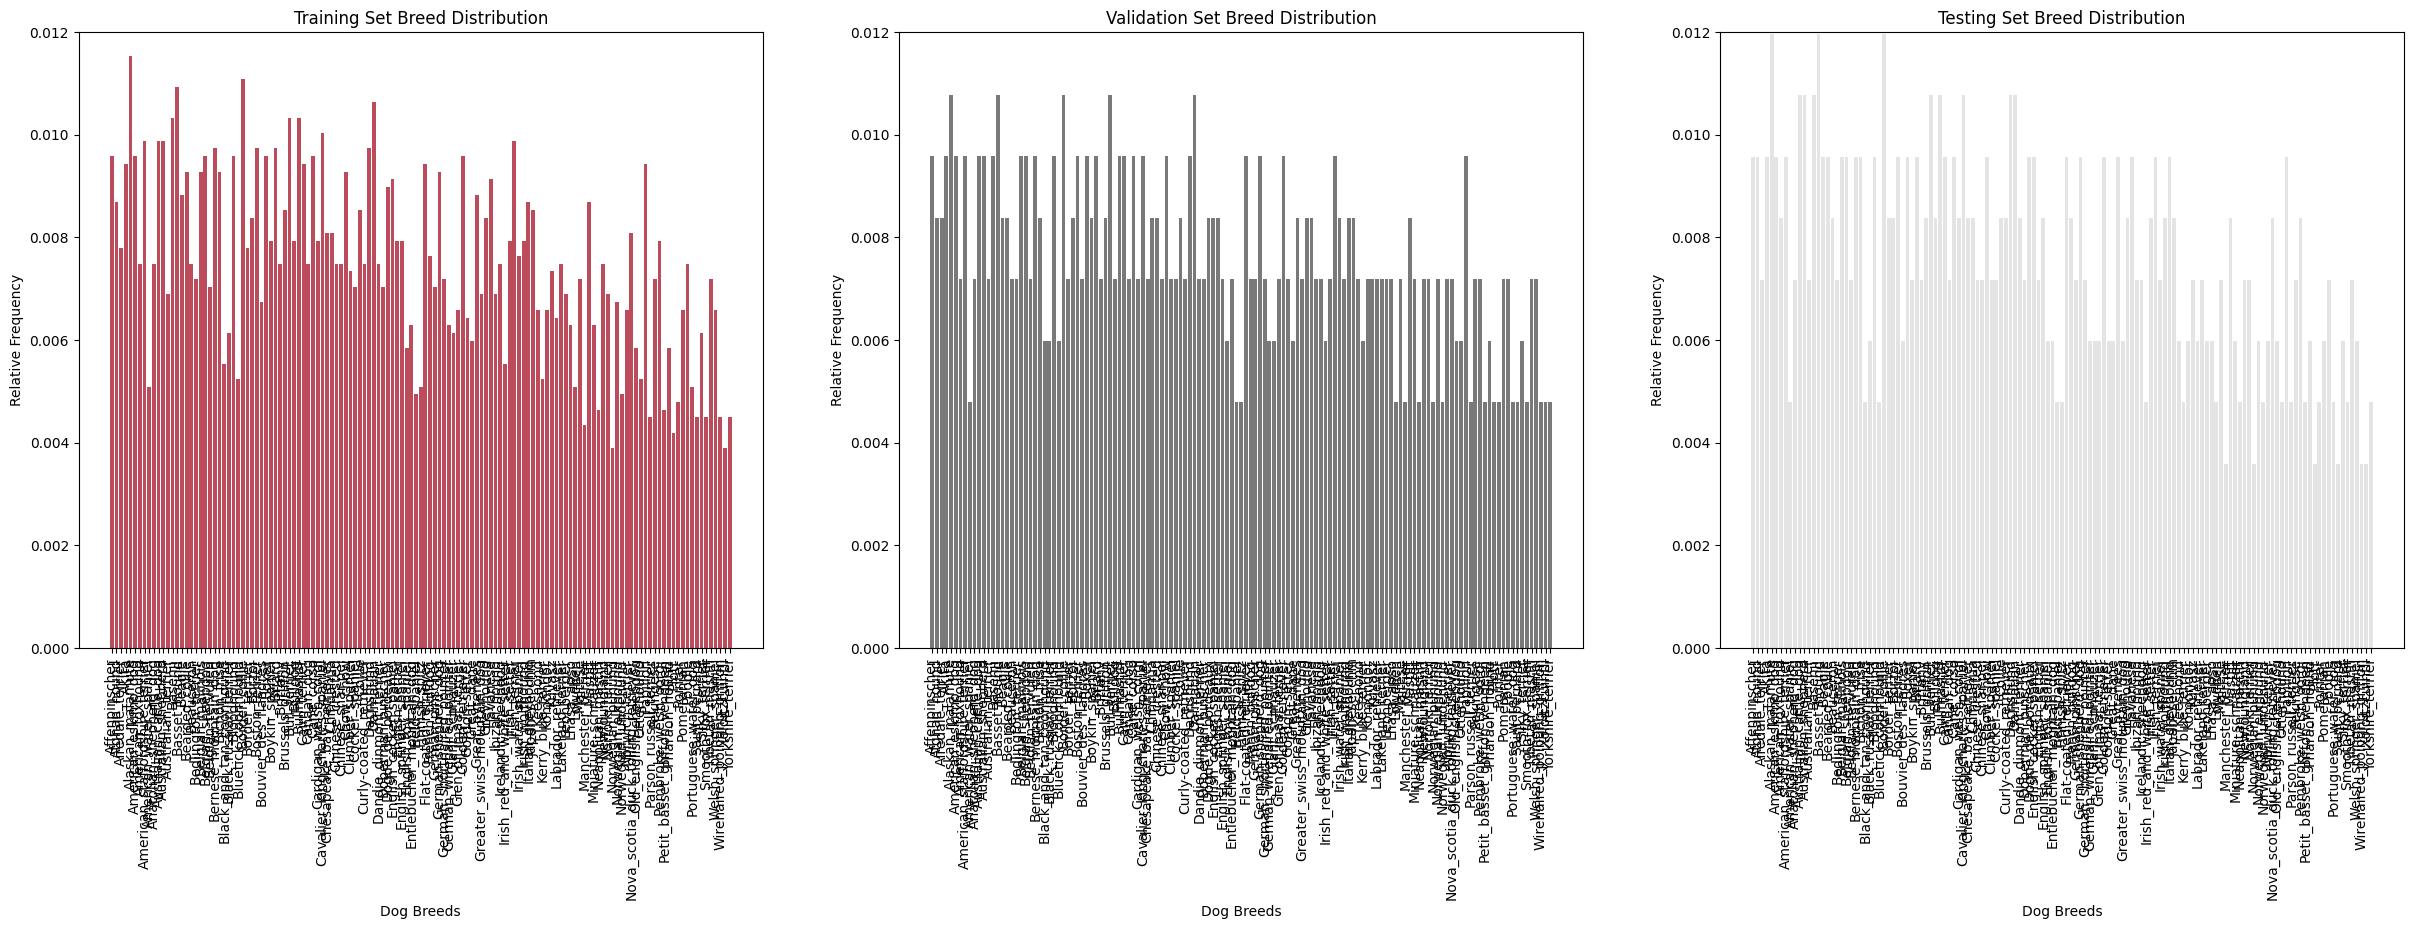

In [3]:
# Creat Pandas DataFrame for Analyzing and Visualizations
train_targets_df = pd.DataFrame(train_targets, columns=dog_names)
valid_targets_df = pd.DataFrame(valid_targets, columns=dog_names)
test_targets_df = pd.DataFrame(test_targets, columns=dog_names)
all_targets_df = pd.concat([train_targets_df, valid_targets_df, test_targets_df])

# Plot the relative distribution of the breeds in each dataset
# Create a Figure
plt.figure(figsize=(30, 8))  # Increase figure size for better readability

# Training set histogram
plt.subplot(1, 3, 1)
plt.bar(train_targets_df.mean().index, train_targets_df.mean().values, color='#A00015', alpha=0.7)
plt.title('Training Set Breed Distribution')
plt.xlabel('Dog Breeds')
plt.ylabel('Relative Frequency')
plt.ylim(0, 0.012)         # set the y lim to the same for better comparibility
plt.xticks(rotation=90)     # Rotate x-ticks for better readability

# Validation set histogram
plt.subplot(1, 3, 2)
plt.bar(valid_targets_df.mean().index, valid_targets_df.mean().values, color='#404040', alpha=0.7)
plt.title('Validation Set Breed Distribution')
plt.xlabel('Dog Breeds')
plt.ylabel('Relative Frequency')
plt.ylim(0, 0.012)         # set the y lim to the same for better comparibility
plt.xticks(rotation=90)     # Rotate x-ticks for better readability

# Testing set histogram
plt.subplot(1, 3, 3)
plt.bar(test_targets_df.mean().index, test_targets_df.mean().values, color='#D9D9D9', alpha=0.7)
plt.title('Testing Set Breed Distribution')
plt.xlabel('Dog Breeds')
plt.ylabel('Relative Frequency')
plt.ylim(0, 0.012)         # set the y lim to the same for better comparibility
plt.xticks(rotation=90)     # Rotate x-ticks for better readability

plt.show()



It seems like they breeds are relativly evenly distributed over the training, validation and testing set. Lets take on closer look to confirm this by overlaying all three of them.

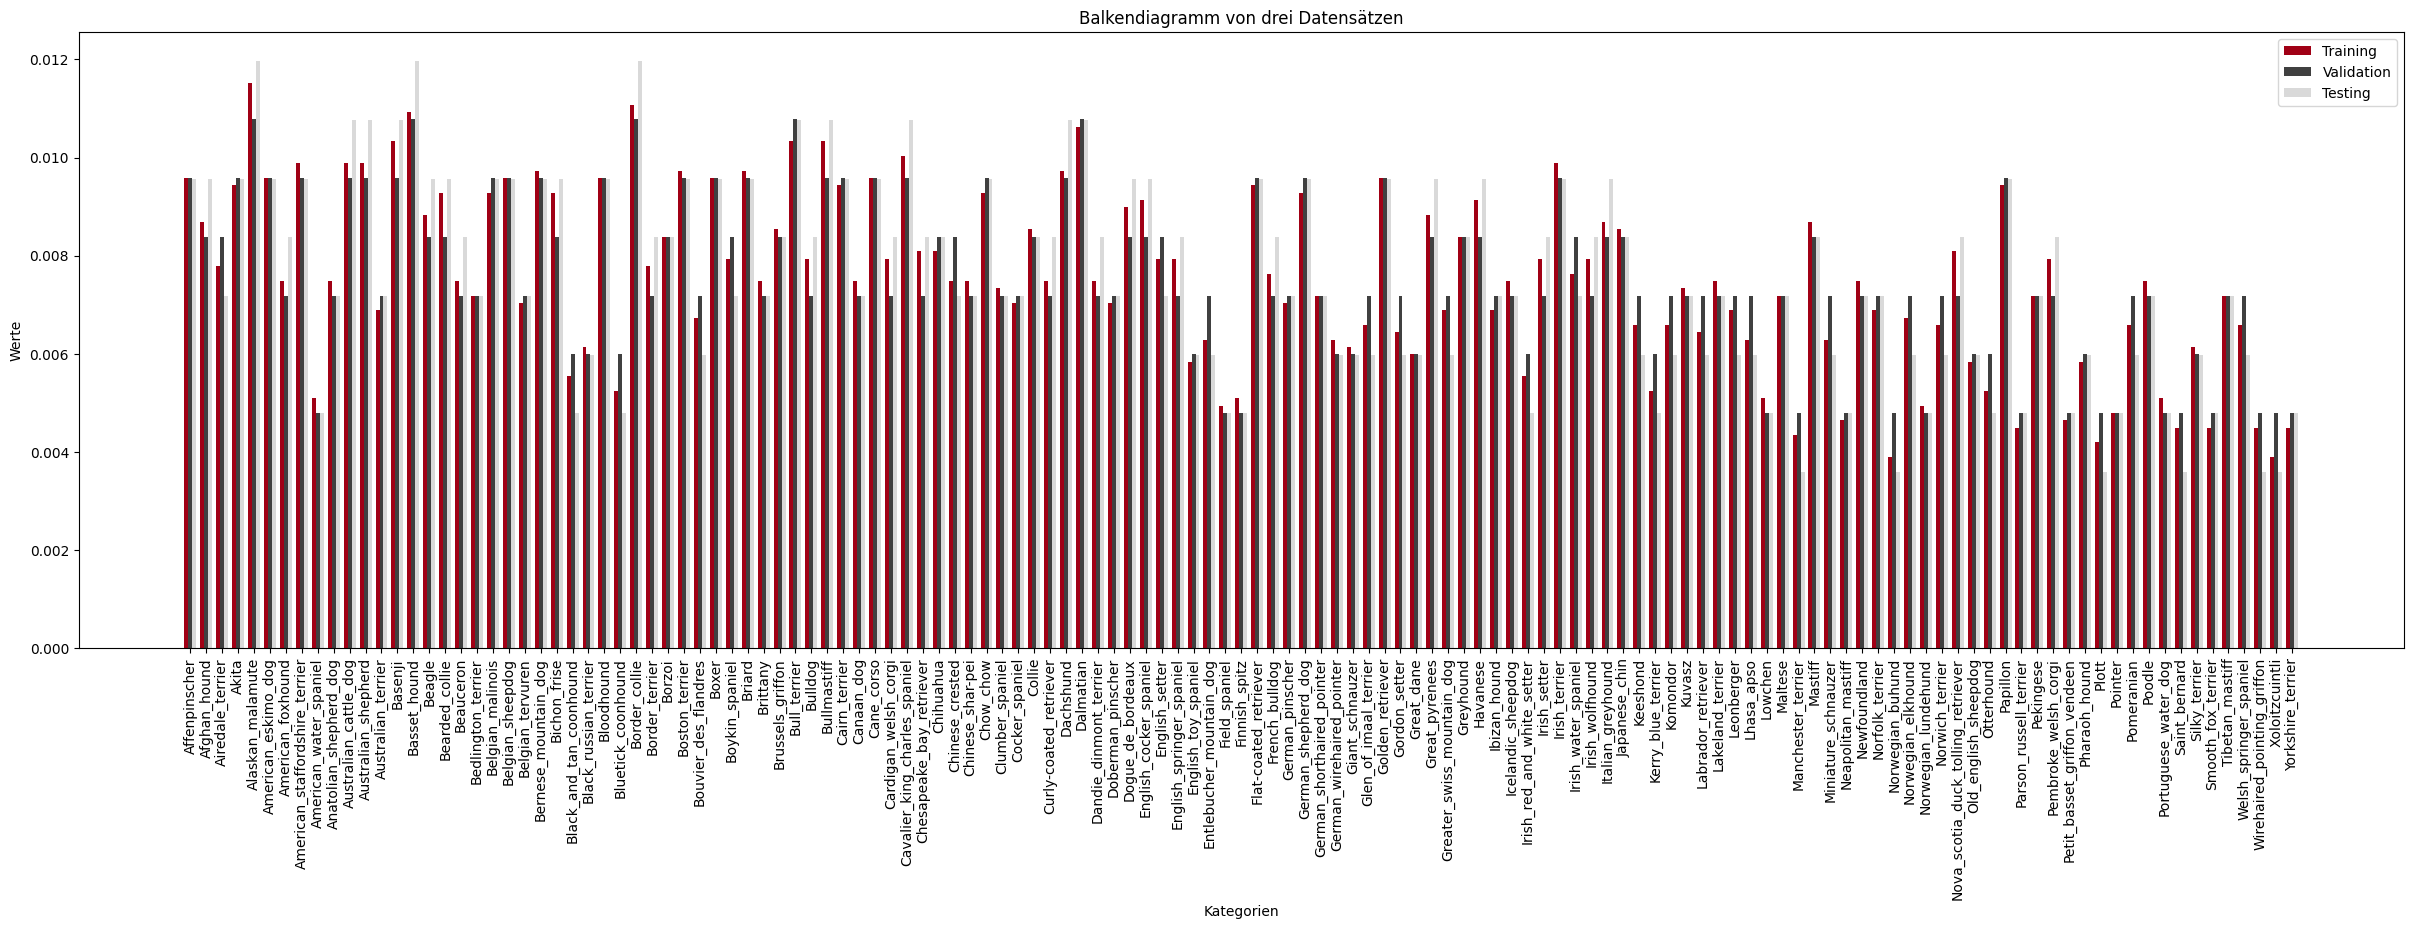

In [4]:
plt.figure(figsize=(30, 8))

# X-Position für jede Kategorie und Breite der Balken
x = np.arange(len(dog_names))
width = 0.25  # Breite der Balken

# Erstelle das Balkendiagramm mit drei verschiedenen Datensätzen
plt.bar(x - width, train_targets_df.mean().values, width=width, label='Training', color='#A00015')
plt.bar(x, valid_targets_df.mean().values, width=width, label='Validation', color='#404040')
plt.bar(x + width, test_targets_df.mean().values, width=width, label='Testing', color='#D9D9D9')

# Setze die Kategorien als X-Achsenmarkierungen
plt.xticks(x, dog_names, rotation=90)

# Beschriftungen und Titel
plt.xlabel('Kategorien')
plt.ylabel('Werte')
plt.title('Balkendiagramm von drei Datensätzen')

# Legende anzeigen
plt.legend()

# Diagramm anzeigen
plt.show()


This Diagramm furthermore confirms, that the breeds are evenly distributed over the different data sets. BUT this and the diagramm below also show that some breeds have less image material to learn from than others and therefore the trained model may have a harder time to fit and later recognize them on the one side and may tend to overfit to the overrepresented breeds.

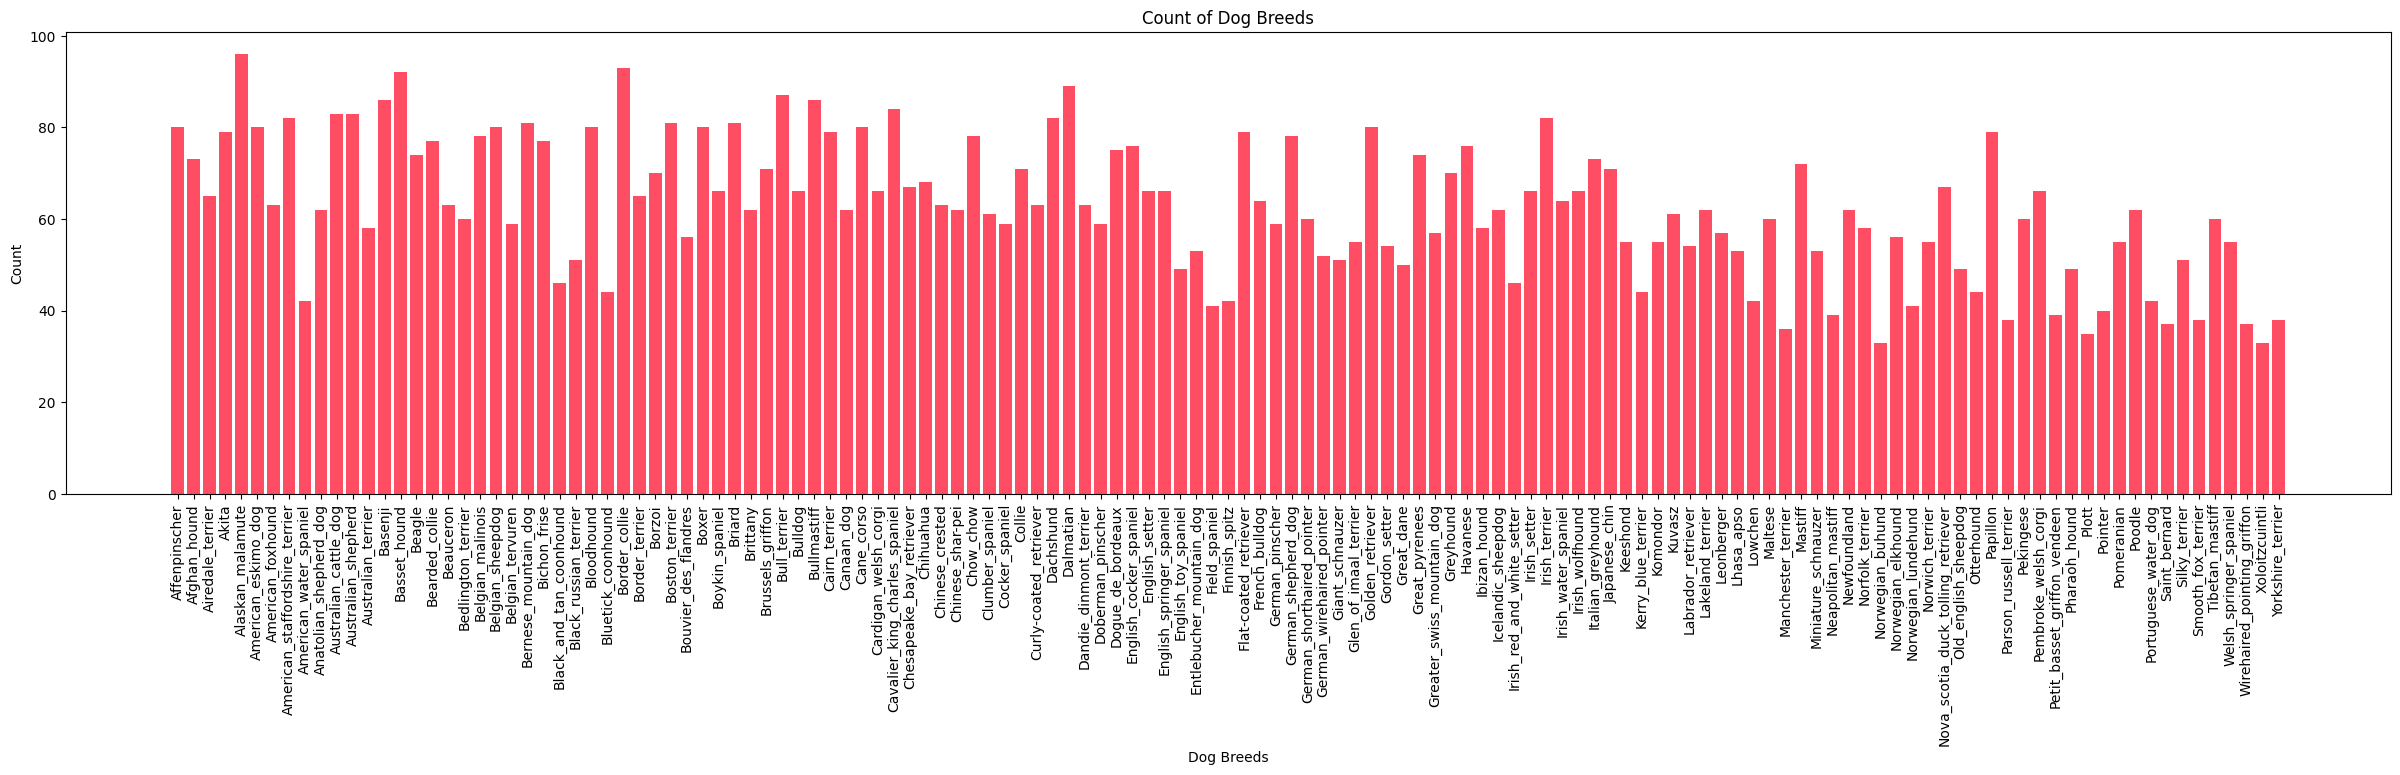

In [5]:
# plot it
plt.figure(figsize=(30, 6))
plt.bar(all_targets_df.sum().index, all_targets_df.sum().values, color='#FF4D64')
plt.xlabel('Dog Breeds')
plt.ylabel('Count')
plt.title('Count of Dog Breeds')
plt.xticks(rotation=90)
plt.show()

**Exploring, Analyzing and Plotting the "pictures"**

In [6]:
# See how the 'files' datasets are structured
train_files

array(['dogImages/train\\095.Kuvasz\\Kuvasz_06442.jpg',
       'dogImages/train\\057.Dalmatian\\Dalmatian_04054.jpg',
       'dogImages/train\\088.Irish_water_spaniel\\Irish_water_spaniel_06014.jpg',
       ..., 'dogImages/train\\029.Border_collie\\Border_collie_02069.jpg',
       'dogImages/train\\046.Cavalier_king_charles_spaniel\\Cavalier_king_charles_spaniel_03261.jpg',
       'dogImages/train\\048.Chihuahua\\Chihuahua_03416.jpg'],
      dtype='<U99')

In [7]:
# Function for retrieving the meta information from a set of files 
def get_meta_from_files(files: np.array)->pd.DataFrame:
    """
    Returns a DataFrame with the meta information of the files in the dataset.

    Args:
        files (list): List of file paths for images.

    Return:
        meta_df (pd:DataFrame): A Dataframe containing the meta information (width, height, channels)
    """
    # 1. create a new DataFrame to store it into
    meta_df = pd.DataFrame(columns=['width', 'height', 'channels'])

    # 2. go trough all files and retrieve the meta data
    for file in tqdm(files):
        #read the picture
        img_temp = cv2.imread(file)

        #get the relevant info
        width = int(img_temp.shape[0])
        height = int(img_temp.shape[1])
        channels = int(img_temp.shape[2])

        #append the row to the df
        meta_df = pd.concat([meta_df, pd.DataFrame([[width, height, channels]], columns=['width', 'height', 'channels'])], ignore_index=True)
    
    return meta_df

# Explore the Dimensions of the provided images in the datasets
# get the width, hight and number of channels for the different datasets
# 1. create a all_files array, that contains all image paths
all_files = np.append(train_files, np.append(test_files, valid_files, axis=0), axis=0)

# 2. create a new DataFrame to store it into
train_files_meta_df = get_meta_from_files(train_files)
valid_files_meta_df = get_meta_from_files(valid_files)
test_files_meta_df = get_meta_from_files(test_files)
all_files_meta_df = pd.concat([train_files_meta_df, valid_files_meta_df, test_files_meta_df])

100%|██████████| 836/836 [00:04<00:00, 173.61it/s]


In [8]:
# Get a few basic statistics of the width and height
print(f"WIDTH: max {all_files_meta_df['width'].max()} // min {all_files_meta_df['width'].min()} // mean {all_files_meta_df['width'].mean():.2f} // median {all_files_meta_df['width'].median()}")
print(f"HEIGHT: max {all_files_meta_df['height'].max()} // min {all_files_meta_df['height'].min()} // mean {all_files_meta_df['height'].mean():.2f} // median {all_files_meta_df['height'].median()}")

WIDTH: max 4003 // min 113 // mean 529.04 // median 467.0
HEIGHT: max 4278 // min 105 // mean 567.03 // median 500.0


In [9]:
# Melt the df for better sns usage for the boxplot
train_files_meta_df_melt = train_files_meta_df[['width', 'height']].reset_index().melt(id_vars='index', var_name='dimension', value_name='pixels')
valid_files_meta_df_melt = valid_files_meta_df[['width', 'height']].reset_index().melt(id_vars='index', var_name='dimension', value_name='pixels')
test_files_meta_df_melt = test_files_meta_df[['width', 'height']].reset_index().melt(id_vars='index', var_name='dimension', value_name='pixels')

In [10]:
train_files_meta_df_melt.head()

,index,dimension,pixels
0,0,width,427
1,1,width,332
2,2,width,533
3,3,width,320
4,4,width,370


C:\Users\P334257\AppData\Local\Temp\1\ipykernel_21244\4047687208.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1, 0].legend()
C:\Users\P334257\AppData\Local\Temp\1\ipykernel_21244\4047687208.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1, 1].legend()
C:\Users\P334257\AppData\Local\Temp\1\ipykernel_21244\4047687208.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1, 2].legend()


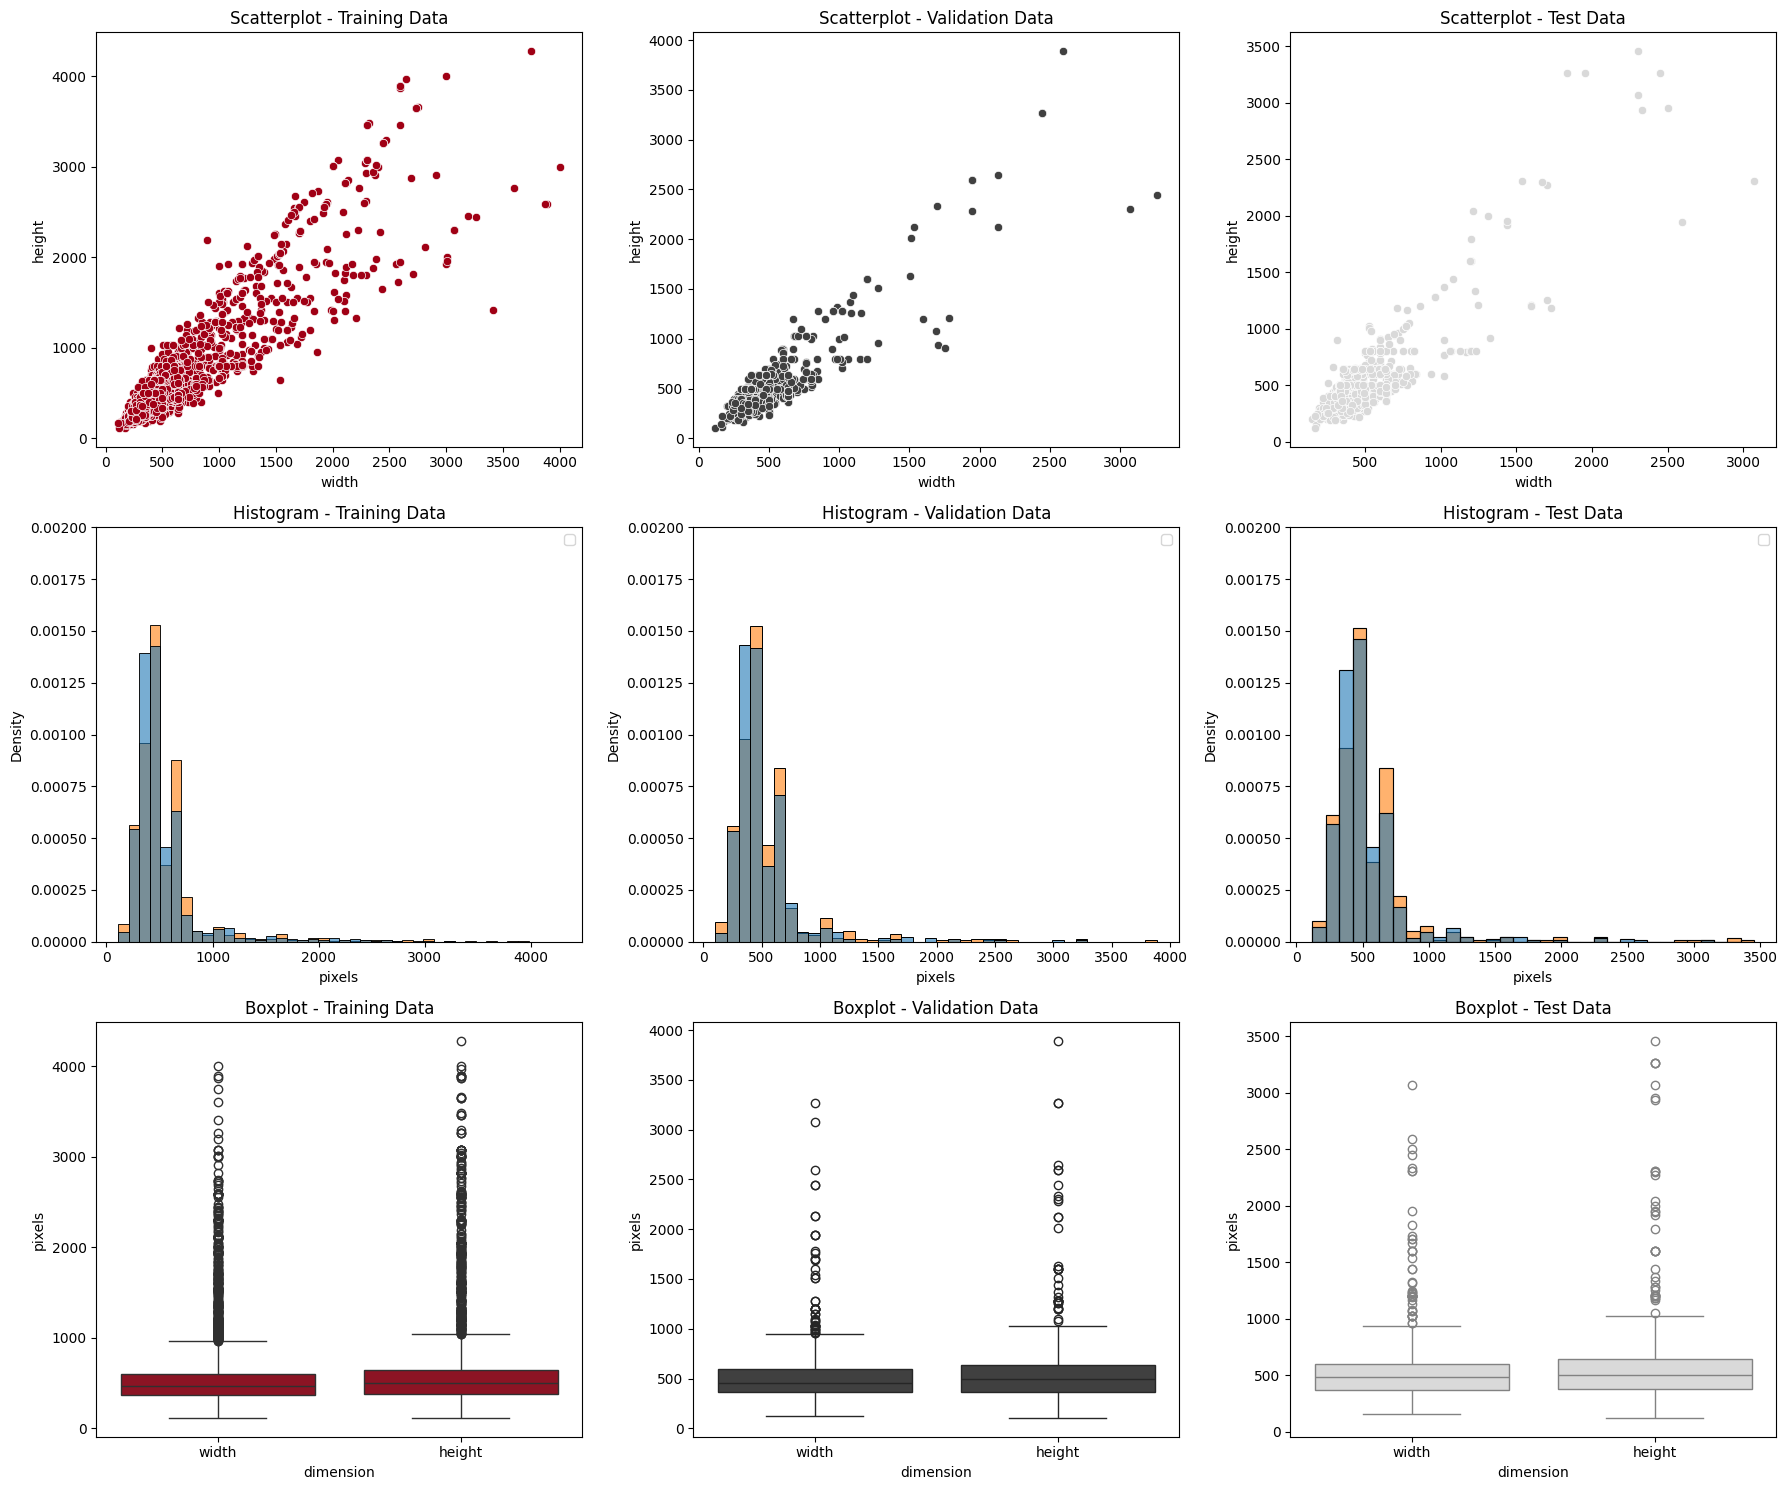

In [13]:
# Erstelle eine Figur mit drei Zeilen und drei Spalten
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Scatterplots for training, validation and test-sets
sns.scatterplot(data=train_files_meta_df, x='width', y='height', ax=axes[0, 0], color='#A00015')
axes[0, 0].set_title('Scatterplot - Training Data')
sns.scatterplot(data=valid_files_meta_df, x='width', y='height', ax=axes[0, 1], color='#404040')
axes[0, 1].set_title('Scatterplot - Validation Data')
sns.scatterplot(data=test_files_meta_df, x='width', y='height', ax=axes[0, 2], color='#D9D9D9')
axes[0, 2].set_title('Scatterplot - Test Data')

# Histogramms for training, validation and test-sets
sns.histplot(data=train_files_meta_df_melt, x='pixels', stat='density', hue='dimension', binwidth=100, ax=axes[1, 0], alpha=0.6)
axes[1, 0].set_title('Histogram - Training Data')
axes[1, 0].set_ylim(0, 0.002)   
axes[1, 0].legend()
sns.histplot(data=valid_files_meta_df_melt, x='pixels', stat='density', hue='dimension', binwidth=100, ax=axes[1, 1], alpha=0.6)
axes[1, 1].set_title('Histogram - Validation Data')
axes[1, 1].set_ylim(0, 0.002)  
axes[1, 1].legend()
sns.histplot(data=test_files_meta_df_melt, x='pixels', stat='density', hue='dimension', binwidth=100, ax=axes[1, 2], alpha=0.6)
axes[1, 2].set_title('Histogram - Test Data')
axes[1, 2].set_ylim(0, 0.002)  
axes[1, 2].legend()

# Boxplots for training, validation and test-sets
sns.boxplot(data=train_files_meta_df_melt, x='dimension', y='pixels', ax=axes[2, 0], color='#A00015')
axes[2, 0].set_title('Boxplot - Training Data')
sns.boxplot(data=valid_files_meta_df_melt, x='dimension', y='pixels', ax=axes[2, 1], color='#404040')
axes[2, 1].set_title('Boxplot - Validation Data')
sns.boxplot(data=test_files_meta_df_melt, x='dimension', y='pixels', ax=axes[2, 2], color='#D9D9D9')
axes[2, 2].set_title('Boxplot - Test Data')

# Engere Anordnung der Plots
plt.tight_layout()

# Diagramm anzeigen
plt.show()

So above we did a scatter plot, histogramm with relativ occurence and boxplots of the width and height in each dataset. What is there to see and take away?

Scatterplot:
- Most images seem concentrated in a region with low width and height values, suggesting relatively consistent image sizing.
- Visualized outliers (points that deviate from the main cluster of data) could indicate particularly large or irregularly formatted images.
- Just taking a look at the Scatterplot you may think the validation and testing datasets may have less outliers.

Histogramm (relative occurence of height/width in pixels):
- The majority of images have low width and height, corresponding to a higher density of bars in these regions.
- The decrease in density as image size increases reflects that larger images occur less frequently.
- Similar distributions across training, validation, and test datasets suggest consistent preparation and splitting of datasets.

Boxplots:
- The box shows that the main body of the data is relatively concentrated, with outliers above the box.
- The thick part of the box (between the first and third quartiles) indicates that the middle 50% of image sizes are within a certain range.
- Outliers above the box may represent particularly large images, possibly deviating image formats or resolutions.

**Conclusion:**

- Data Consistency: The similarity of plots for training, validation, and test sets indicates that all datasets come from a similar distribution, which is good for the robustness and generalizability of your model.
- Outlier Handling: It might be beneficial to examine outliers closely before training a model to ensure they do not adversely affect model performance.
- Image Size Homogeneity: Relatively uniform image sizing often aids in training stability, as varying sizes typically require preprocessing for normalization.

### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [14]:
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


In [15]:
# Get an impression of the human_files
human_files

array(['lfw\\Muhammad_Ali\\Muhammad_Ali_0001.jpg',
       'lfw\\Yoko_Ono\\Yoko_Ono_0001.jpg',
       'lfw\\Svetlana_Koroleva\\Svetlana_Koroleva_0002.jpg', ...,
       'lfw\\Mahmoud_Abbas\\Mahmoud_Abbas_0028.jpg',
       'lfw\\Ernie_Fletcher\\Ernie_Fletcher_0002.jpg',
       'lfw\\John_Ashcroft\\John_Ashcroft_0028.jpg'], dtype='<U84')

---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

(250, 250, 3)
[[ 68  68 116 116]]
Number of faces detected: 1
x: 68
y: 68
w: 116
h: 116


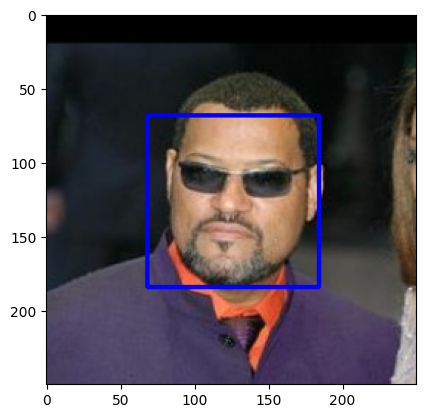

In [16]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
print(img.shape)
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)
print(faces)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    print(f"x: {x}")
    print(f"y: {y}")
    print(f"w: {w}")
    print(f"h: {h}")
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [17]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [18]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

from tqdm import tqdm

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_test = list()
for human in tqdm(human_files_short):
    human_test.append(face_detector(human))

dog_test = list()
for dog in tqdm(dog_files_short):
    dog_test.append(face_detector(dog))

print(f"{np.mean(human_test)*100:.2f}% were correct identified as humans")
print(f"{np.mean(dog_test)*100:.2f}% of the dogs were falsly identified as humans")

100%|██████████| 100/100 [00:10<00:00,  9.99it/s]

99.00% were correct identified as humans
12.00% of the dogs were falsly identified as humans


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__ Of course an disclaimer can help in order to get a quick solution up and running. But in reality it is not reasonable to expect users to only provide front face images to the classifier. Maybe they turned their head a little to the side, they are wearing a hat and the shadow covers part of it. Many cases of an only partially visible or obscurred face are thinkable. Therefore the deployed system should be able to handle this. Here deep learning models could be used. Some examples from a quick search may be: MTCNN (Multi-task Cascaded Convolutional Networks), Faster R-CNN with Feature Pyramid Networks (FPN), RetinaFace, YOLO (You Only Look Once) models with custom annotations for face recognition, Deep Neural Networks with Attention Mechanisms or Face Detection Data Sets and Benchmarks (FDB) no name a few.

---------------------

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [ ]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [19]:
from keras.applications.resnet50 import ResNet50 as RN50

# define ResNet50 model
ResNet50_model_dog_class = RN50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape


(nb_samples, rows, columns, channels),

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape


(1, 224, 224, 3).


The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 


(nb_samples, 224, 224, 3).


Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [20]:
from keras.preprocessing import image                  

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [21]:
import os
import sys
import contextlib
from keras.applications.resnet50 import preprocess_input, decode_predictions

# Define a context manager to suppress stdout and stderr for a cleaner output
@contextlib.contextmanager
def suppress_stdout_stderr():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        try:
            sys.stdout = devnull
            sys.stderr = devnull
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr



def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    with suppress_stdout_stderr():
        prediction = np.argmax(ResNet50_model_dog_class.predict(img))
    return prediction

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [22]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [23]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

human_test_rn50 = list()
for human in tqdm(human_files_short):
    human_test_rn50.append(dog_detector(human))

dog_test_rn50 = list()
for dog in tqdm(dog_files_short):
    dog_test_rn50.append(dog_detector(dog))

print(f"{np.mean(human_test_rn50)*100:.2f}% of the humans were falsly identified as dogs")
print(f"{np.mean(dog_test_rn50)*100:.2f}% of the dogs were correctly identified as dogs")

100%|██████████| 100/100 [00:20<00:00,  4.82it/s]

0.00% of the humans were falsly identified as dogs
100.00% of the dogs were correctly identified as dogs


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [24]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:03<00:00, 243.66it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

In the beginning I tried larger and more complex models (including deep convolutional layer, batch normalization, flattening). But with my local machine (no gpu usage possible due to no nvidia chipset) I ended up in really really long training times (over several hours for just 10 epochs!). Therefore I went back to the "drawing board" and I followed the architecture of the recommended model shown above, but made a few adjustments to up the accuracy while not sacrifising too much run-time.

Additional thoughts to my first attempts:
1. First Architectures resulted in well over a million of parameters. Training them with "just" 6000-7000 images probably wont lead to good generalization results but rather in a well overfitted model, cause the available data is insufficient to fully train these complex architectures.

__The final Model:__

**Conv2D Layers** >> Convolutional layers are crucial for detecting spatial hierarchies in images. They apply filters to the input images to create feature maps. These layers help in capturing features such as edges, textures, and more complex patterns as the depth of the network increases. The series of convolutions increases the level of abstraction and complexity of the patterns that can be recognized. In the first layer I used 32 Filters with a (3, 3) Kernel going up to 128 Filters with a (3, 3) Kernle on the last layer. Progression from 32 to 128 filters allows the model to learn a diverse set of features. The increasing number of filters as the layers go deeper enables capturing more intricate features.

**MaxPooling2D Layers** >> Max pooling reduces the spatial dimensions (width and height) of the feature maps, effectively reducing the computational cost and also helping in controlling overfitting. Downsampling helps the network become more invariant to small translations and distortions of the input images, making the model more robust.

**GlobalAveragePooling2D** >> This layer replaces the fully connected layers by averaging the feature map of each channel. It reduces the data handled by the dense layers, preserving spatial features while decreasing overfitting risk and ensuring that each feature is taken into account regardless of its position.

**Dense Layers** >> Dense layers are crucial for the classification part. They combine features from convolutional layers to make final predictions. The first dense layer with 512 units allows for complex transformations of the feature maps into a format useful for classification. The final dense layer with 133 units outputs probabilities, each corresponding to a dog breed category. Typically, the last dense layer would use a softmax activation function to output probabilities over the 133 classes.

**Dropout** >> Dropout is a regularization technique that helps prevent overfitting during training by randomly setting a fraction of units to zero at each update during training. It prevents the co-adaptation of features, enabling the network to generalize better on unseen data.

__Overall-Architecture Benefits:__
- **Hierarchical Feature Extraction:** The combination of convolutional layers and pooling layers captures hierarchical feature representations effectively.
- **Reduced Overfitting:** The use of dropout and pooling layers helps to maintain model generalization, a crucial aspect when dealing with complex datasets such as images.
- **Efficient Final Layers:** Global average pooling followed by dense layers leverage learned features to make robust classifications.
This structure, with its balance of convolutional, pooling, dropout, and dense layers, allows the model to effectively learn spatial hierarchies and features necessary for discriminating between different breeds of dogs, even in varied and complex image datasets.



In [32]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

# Get input parameters for building the model
num_dog_breeds = len(dog_names)
pixel_w = train_tensors.shape[1]
pixel_h = train_tensors.shape[2]

### TODO: Define your architecture.
model = Sequential([
    # First Convolutional Layer
    Conv2D(32, (2, 2), activation='relu', input_shape=(pixel_w, pixel_h, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Global Average Pooling
    GlobalAveragePooling2D(),

    # Fully connected layers
    Dense(256, activation='relu'),
    Dropout(0.5),                                       # > to prevent Overfitting
    Dense(num_dog_breeds, activation='softmax')
])

# Model Summary
model.summary()

c:\Users\P334257\Documents\Udacity\04_Data_Science\05_Capstone\01_Dog_Breed_Classifier\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 223, 223, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 133)            │        34,181 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,973 (624.89 KB)

 Trainable params: 159,973 (624.89 KB)

 Non-trainable params: 0 (0.00 B)

### Compile the Model

In [33]:
from tensorflow.keras.optimizers import Adam

#Optimizers
standard = 'rmsprop'
adam = Adam(learning_rate=0.001)        # > experimented with

model.compile(optimizer=standard, loss='categorical_crossentropy', metrics=['accuracy'])

### Choosing Metrics

#### Which metrics exist in this context and we can choose from?

__Accuracy:__

*Description:* Measures the proportion of true results (both true positives and true negatives) among the total number of cases examined.<br>
*Why:* Accuracy gives a quick overview of the model's performance, but it may not be sufficient if the classes are imbalanced.

__Precision, Recall, and F1-Score:__

- **Precision:** The ratio of correctly predicted positive observations to the total predicted positives. It shows the model's ability to not label a negative sample as positive.
- **Recall (Sensitivity):** The ratio of correctly predicted positive observations to all actual positives. It measures the ability of the model to find all the relevant cases.
- **F1-Score:** The weighted average of Precision and Recall. It is more informative than accuracy, especially if you have an uneven class distribution.
Why: These metrics provide insights into the performance of the model with respect to false positives and false negatives, which is critical if you have classes with varying amounts of data.

__Confusion Matrix:__

*Description:* A table used to describe the performance of a classification model on a set of test data for which the true values are known.<br>
*Why:* It allows for easy identification of where the models make mistakes, such as confusion between specific classes.


__ROC AUC Score (Receiver Operating Characteristic - Area Under Curve):__

*Description:* A performance measurement for classification problems at various thresholds settings. ROC is a probability curve and AUC represents the degree or measure of separability. <br>
*Why:* Although used more in binary classification, it can be adapted for multi-class to understand the class separation capability of the model.


__Top-k Accuracy:__

*Description:* Measures how often the true label is among the top k predicted labels.<br>
*Why:* Useful in scenarios where multiple labels might be acceptable, or when slight misclassifications are tolerable, providing a measure of the rank order accuracy.

__Log Loss:__

*Description:* Logarithmic loss measures the performance of a classification model whose output is a probability value between 0 and 1.<br>
*Why:*  It is especially useful for models that give probability scores as predictions, as it penalizes incorrect classifications with greater severity.


#### Which metrics did I choose, what for and why?

I opted for accuracy and validation loss for the training of the model. Accuracy directly evaluates the correct classifications in proportion to the samples and is a straightforwards and intuitive measure. Since the dataset is balanced relativly good can be a meaningfull metric. Furthermore I used validation loss in order to monitor a good generalization to unseen data.

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint  
from tensorflow.keras import layers

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.h5',#hdf5
                               monitor='val_accuracy',  
                               verbose=10,
                               save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=10)

Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.01078, saving model to saved_models/weights.best.from_scratch.h5


Epoch 2/10

Epoch 2: val_accuracy improved from 0.01078 to 0.01437, saving model to saved_models/weights.best.from_scratch.h5


Epoch 3/10

Epoch 3: val_accuracy improved from 0.01437 to 0.01796, saving model to saved_models/weights.best.from_scratch.h5


Epoch 4/10

Epoch 4: val_accuracy improved from 0.01796 to 0.02036, saving model to saved_models/weights.best.from_scratch.h5


Epoch 5/10

Epoch 5: val_accuracy improved from 0.02036 to 0.02754, saving model to saved_models/weights.best.from_scratch.h5


Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.02754
Epoch 7/10

Epoch 7: val_accuracy improved from 0.02754 to 0.03114, saving model to saved_models/weights.best.from_scratch.h5


Epoch 8/10

Epoch 8: val_accuracy did not improve from 0.03114
Epoch 9/10

Epoch 9: val_accuracy improved from 0.03114 to 0.03353, saving model to saved_models/weights.best.from_scratch.h5


Epoch 10/10

Epoch 10: val_accuracy improved from 0.03353 to 0.04311, saving model to saved_models/weights.best.from_scratch.h5


### Load the Model with the Best Validation Loss

In [35]:
model.load_weights('saved_models/weights.best.from_scratch.h5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [36]:
test_tensors.shape

(836, 224, 224, 3)

In [37]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = list()

for tensor in tqdm(test_tensors):
    with suppress_stdout_stderr():
        dog_breed_predictions.append(np.argmax(model.predict(np.expand_dims(tensor, axis=0))))

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

100%|██████████| 836/836 [01:02<00:00, 13.40it/s]

Test accuracy: 4.3062%


Test Accuracy is really bad - but enough to fullfill the +1% criterion.

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [56]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [67]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

c:\Users\P334257\Documents\Udacity\04_Data_Science\05_Capstone\01_Dog_Breed_Classifier\.venv\Lib\site-packages\keras\src\layers\pooling\base_global_pooling.py:12: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ global_average_pooling2d_10     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 133)            │        68,229 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,229 (266.52 KB)

 Trainable params: 68,229 (266.52 KB)

 Non-trainable params: 0 (0.00 B)

### Compile the Model

In [68]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [69]:
def plot_history_train(history):
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 1/20
328/334 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1103 - loss: 12.1182
Epoch 1: val_loss improved from inf to 3.50779, saving model to saved_models/weights.best.VGG16.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1129 - loss: 12.0267 - val_accuracy: 0.4479 - val_loss: 3.5078
Epoch 2/20
301/334 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5581 - loss: 2.3983
Epoch 2: val_loss improved from 3.50779 to 2.37955, saving model to saved_models/weights.best.VGG16.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5617 - loss: 2.3803 - val_accuracy: 0.5749 - val_loss: 2.3796
Epoch 3/20
310/334 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7370 - loss: 1.2286
Epoch 3: val_loss improved from 2.37955 to 2.18996, saving model to saved_models/weights.best.VGG16.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7370 - loss: 1.2287 - val_accuracy: 0.6251 - val_loss: 2.1900
Epoch 4/20
306/334 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8252 - loss: 0.7304
Epoch 4: val_loss improved from 2.18996 to 1.99453, saving model to saved_models/weights.best.VGG16.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8244 - loss: 0.7379 - val_accuracy: 0.6814 - val_loss: 1.9945
Epoch 5/20
327/334 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8625 - loss: 0.5707
Epoch 5: val_loss improved from 1.99453 to 1.92808, saving model to saved_models/weights.best.VGG16.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8624 - loss: 0.5706 - val_accuracy: 0.6707 - val_loss: 1.9281
Epoch 6/20
327/334 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9003 - loss: 0.3510
Epoch 6: val_loss improved from 1.92808 to 1.78072, saving model to saved_models/weights.best.VGG16.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9002 - loss: 0.3523 - val_accuracy: 0.7006 - val_loss: 1.7807
Epoch 7/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9283 - loss: 0.2568
Epoch 7: val_loss did not improve from 1.78072
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9283 - loss: 0.2570 - val_accuracy: 0.6958 - val_loss: 1.8785
Epoch 8/20
309/334 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9429 - loss: 0.2018
Epoch 8: val_loss did not improve from 1.78072
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9424 - loss: 0.2037 - val_accuracy: 0.7186 - val_loss: 1.8070
Epoch 9/20
317/334 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9502 - loss: 0.1637
Epoch 9: val_loss did not improve from 1.78072
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9502 - loss: 0.1641 - val_accuracy: 0.7246 - val_loss: 1.8112
Epoch 10/20
310/334 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9654 - loss: 0.1296
Epoch 10: val_loss improved from 1.78072 to 1.

334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9651 - loss: 0.1299 - val_accuracy: 0.7377 - val_loss: 1.7314
Epoch 11/20
315/334 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9681 - loss: 0.0987
Epoch 11: val_loss did not improve from 1.73139
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9681 - loss: 0.0988 - val_accuracy: 0.7329 - val_loss: 1.8606
Epoch 12/20
316/334 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9773 - loss: 0.0655
Epoch 12: val_loss did not improve from 1.73139
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9772 - loss: 0.0663 - val_accuracy: 0.7353 - val_loss: 1.8718
Epoch 13/20
311/334 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9870 - loss: 0.0463
Epoch 13: val_loss did not improve from 1.73139
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9867 - loss: 0.0473 - val_accuracy: 0.7198 - val_loss: 1.9859
Epoch 14/20
324/334 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9867 - loss: 0.0403
Epoch 14: val_loss did not improve from 

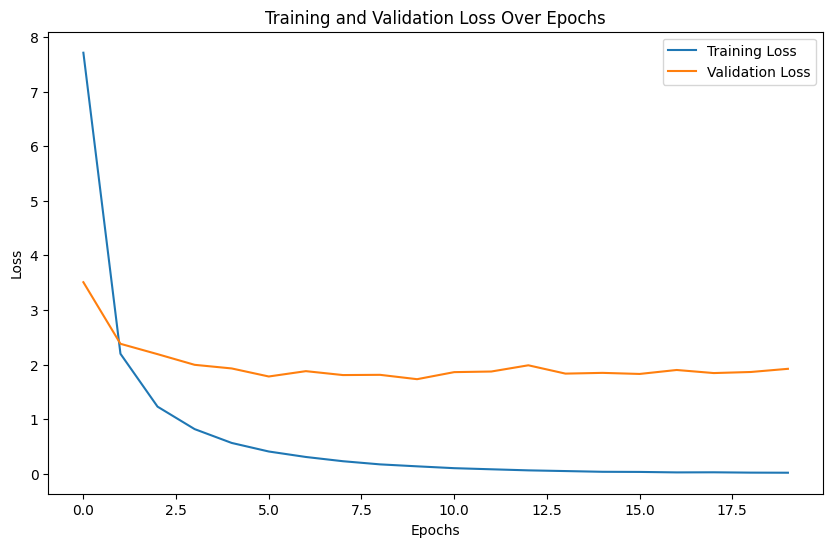

In [70]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.h5', 
                               verbose=1, save_best_only=True, monitor='val_loss')

history = VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

plot_history_train(history)

### Load the Model with the Best Validation Loss

In [71]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.h5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [72]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = list()

# get index of predicted dog breed for each image in test set
for feature in tqdm(test_VGG16):
    with suppress_stdout_stderr():
        VGG16_predictions.append(np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))))

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

100%|██████████| 836/836 [00:53<00:00, 15.68it/s]

Test accuracy: 71.1722%


### Predict Dog Breed with the Model

In [73]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [74]:
# Test predict function
image_path = 'dogImages/test/032.Boston_terrier/Boston_terrier_02256.jpg'
print(VGG16_predict_breed(image_path))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Boston_terrier


---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [75]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture, Compiling and Training

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

First I had to choose between the different Base Architectures (VGG-19, ResNet-50, Inception and Xception). Herefore on the one hand I tested the results of a simple architecture with just a GlobalAveragePooling2D and a Dense Layer following the PreTrained Bottleneck Features. The Xception yielded the better results instantly. On the other hand I made a qualitative search on the internet comparing these four. The summary was:

- **VGG-19** is exemplary for transfer learning due to its simplicity, but less efficient regarding speed and memory.
- **ResNet-50** excels with deep networks due to its residual learning framework but can be complex.
- **Inception** achieves high accuracy and efficiency using its sophisticated module strategy, yet is relatively complex.
- **Xception** further simplifies Inception while maintaining efficiency but is best suited for larger datasets.

Since I am really low on CPU performance and have no GPU to use, and it obtained a better results than ResNet-50, and VGG-16 (previous chapter) I opted for Xcpetion.

__From here I then iterated with different architectures:__

1. **SIMPLE:** X-Ception >> GlobalAveragePooling2D >> Dense Layer as Output <br>
Results >> Test-Accuracy ~ 85% // Validation Loss 0.44 - 0.55 // Precision (wavg) 0.88 // Recall (wavg) 0.86 // F1-Score (wavg) 0.86
             

2. **SIMPLE+**: added Dropout Layer <br>
Results >> Test-Accuracy ~ 85% // Validation Loss 0.46 - 0.56 // Precision (wavg) 0.88 // Recall (wavg) 0.85 // F1-Score (wavg) 0.85

3. **SIMPLE++**: added another Dense Layer <br>
Results >> Test-Accuracy ~ 12% // Validation Loss 3.4 - 4.8 // Precision (wavg) 0.83 // Recall (wavg) 0.12 // F1-Score (wavg) 0.19

4. **SIMPLE+ TUNING**: tuned parameters like Optimizer, DropOut Rate and Batch Size <br>
Results >> Test-Accuracy ~ 85% // Validation Loss 0.44 - 0.61 // Precision (wavg) 0.87 // Recall (wavg) 0.85 // F1-Score (wavg) 0.85

Since none of the iterations got substantially better I stayed with the first, SIMPLE one. The final architecture is well-suited for the problem of dog breed classification as it is robust, generalizes well to unseen data, and performs efficiently for the given task.

### SIMPLE Architecture

In [80]:
### SIMPLE Architecture
# Build the model
Xception_model_simple = Sequential()
Xception_model_simple.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
Xception_model_simple.add(Dense(133, activation='softmax'))

Xception_model_simple.summary()

# Compile the model
Xception_model_simple.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ global_average_pooling2d_13     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 133)            │       272,517 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 272,517 (1.04 MB)

 Trainable params: 272,517 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.54209, saving model to saved_models/weights.best.Xception_simple.h5


Epoch 2/20

Epoch 2: val_loss improved from 0.54209 to 0.47825, saving model to saved_models/weights.best.Xception_simple.h5


Epoch 3/20

Epoch 3: val_loss improved from 0.47825 to 0.46091, saving model to saved_models/weights.best.Xception_simple.h5


Epoch 4/20

Epoch 4: val_loss did not improve from 0.46091
Epoch 5/20

Epoch 5: val_loss did not improve from 0.46091
Epoch 6/20

Epoch 6: val_loss did not improve from 0.46091
Epoch 7/20

Epoch 7: val_loss did not improve from 0.46091
Epoch 8/20

Epoch 8: val_loss did not improve from 0.46091
Epoch 9/20

Epoch 9: val_loss did not improve from 0.46091
Epoch 10/20

Epoch 10: val_loss did not improve from 0.46091
Epoch 11/20

Epoch 11: val_loss did not improve from 0.46091
Epoch 12/20

Epoch 12: val_loss did not improve from 0.46091
Epoch 13/20

Epoch 13: val_loss did not improve from 0.46091
Epoch 14/20

Epoch 14: val_loss did not improve from 0.46091
Epoch 15/20

Epoch 15: val_loss did not improve from 0.46091
Epoch 16/20

Epoch 16: val_loss did not improve from 0.46091
Epoch 17/20

Epoch 17: val_loss did not improve from 0.46091
Epoch 18/20

Epoch 18: val_loss did not improve from 0.46091
Epoch 19/20

Epoch 19: val_loss did not improve from 0.46091
Epoch 20/20

Epoch 20: val_loss did 

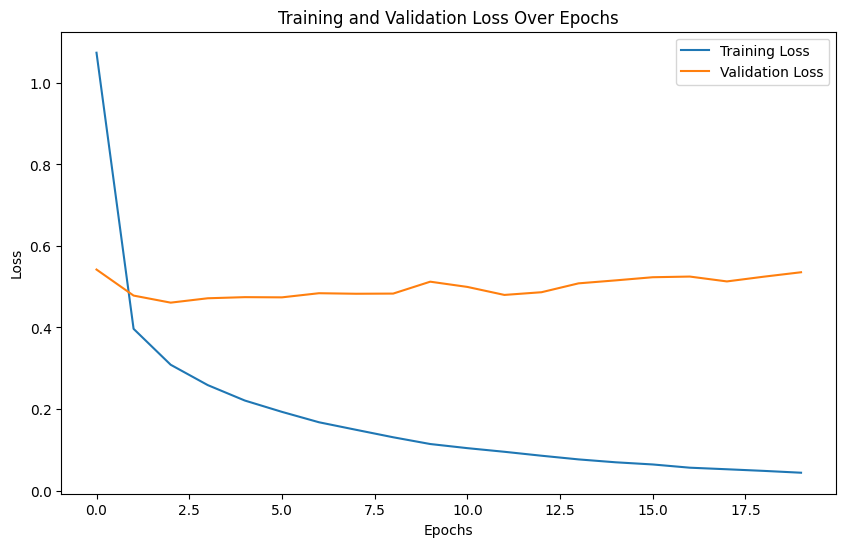

In [81]:
### TODO: Train the model.

# set epochs
epochs = 20

# add callbacks for model checkpointing 
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception_simple.h5', 
                               verbose=1, save_best_only=True, monitor='val_loss')

# train the model and store the training history
history_simple = Xception_model_simple.fit(train_Xception, train_targets, 
                                    validation_data=(valid_Xception, valid_targets),
                                    epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=10)

plot_history_train(history_simple)

In [83]:
from sklearn.metrics import classification_report

### TODO: Load the model weights with the best validation loss.
Xception_model_simple.load_weights('saved_models/weights.best.Xception_simple.h5')

### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
Xception_predictions = list()

for feature in tqdm(test_Xception):
    with suppress_stdout_stderr():
        Xception_predictions.append(np.argmax(Xception_model_simple.predict(np.expand_dims(feature, axis=0))))

# report test accuracy
test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

# print classification report
print(classification_report(np.array(Xception_predictions), np.argmax(test_targets, axis=1), target_names=dog_names))

  0%|          | 0/836 [00:00<?, ?it/s]

100%|██████████| 836/836 [00:52<00:00, 15.80it/s]

Test accuracy: 85.8852%
                                    precision    recall  f1-score   support

                     Affenpinscher       0.88      1.00      0.93         7
                      Afghan_hound       0.88      0.88      0.88         8
                  Airedale_terrier       1.00      0.86      0.92         7
                             Akita       0.88      1.00      0.93         7
                  Alaskan_malamute       1.00      0.91      0.95        11
               American_eskimo_dog       1.00      1.00      1.00         8
                 American_foxhound       0.86      1.00      0.92         6
    American_staffordshire_terrier       1.00      1.00      1.00         8
            American_water_spaniel       0.50      0.67      0.57         3
            Anatolian_shepherd_dog       1.00      0.86      0.92         7
             Australian_cattle_dog       0.89      1.00      0.94         8
               Australian_shepherd       0.78      1.00      0.


c:\Users\P334257\Documents\Udacity\04_Data_Science\05_Capstone\01_Dog_Breed_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P334257\Documents\Udacity\04_Data_Science\05_Capstone\01_Dog_Breed_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P334257\Documents\Udacity\04_Data_Science\05_Capstone\01_Dog_Breed_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no tr

### SIMPLE+ Architecture
Added a Dropout Layer for better generalization

c:\Users\P334257\Documents\Udacity\04_Data_Science\05_Capstone\01_Dog_Breed_Classifier\.venv\Lib\site-packages\keras\src\layers\pooling\base_global_pooling.py:12: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ global_average_pooling2d_14     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 133)            │       272,517 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 272,517 (1.04 MB)

 Trainable params: 272,517 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.56032, saving model to saved_models/weights.best.Xception_simple_plus.h5


Epoch 2/20

Epoch 2: val_loss improved from 0.56032 to 0.48572, saving model to saved_models/weights.best.Xception_simple_plus.h5


Epoch 3/20

Epoch 3: val_loss improved from 0.48572 to 0.46772, saving model to saved_models/weights.best.Xception_simple_plus.h5


Epoch 4/20

Epoch 4: val_loss did not improve from 0.46772
Epoch 5/20

Epoch 5: val_loss improved from 0.46772 to 0.46202, saving model to saved_models/weights.best.Xception_simple_plus.h5


Epoch 6/20

Epoch 6: val_loss did not improve from 0.46202
Epoch 7/20

Epoch 7: val_loss improved from 0.46202 to 0.46080, saving model to saved_models/weights.best.Xception_simple_plus.h5


Epoch 8/20

Epoch 8: val_loss did not improve from 0.46080
Epoch 9/20

Epoch 9: val_loss did not improve from 0.46080
Epoch 10/20

Epoch 10: val_loss did not improve from 0.46080
Epoch 11/20

Epoch 11: val_loss did not improve from 0.46080
Epoch 12/20

Epoch 12: val_loss did not improve from 0.46080
Epoch 13/20

Epoch 13: val_loss did not improve from 0.46080
Epoch 14/20

Epoch 14: val_loss did not improve from 0.46080
Epoch 15/20

Epoch 15: val_loss did not improve from 0.46080
Epoch 16/20

Epoch 16: val_loss did not improve from 0.46080
Epoch 17/20

Epoch 17: val_loss did not improve from 0.46080
Epoch 18/20

Epoch 18: val_loss did not improve from 0.46080
Epoch 19/20

Epoch 19: val_loss did not improve from 0.46080
Epoch 20/20

Epoch 20: val_loss did not improve from 0.46080


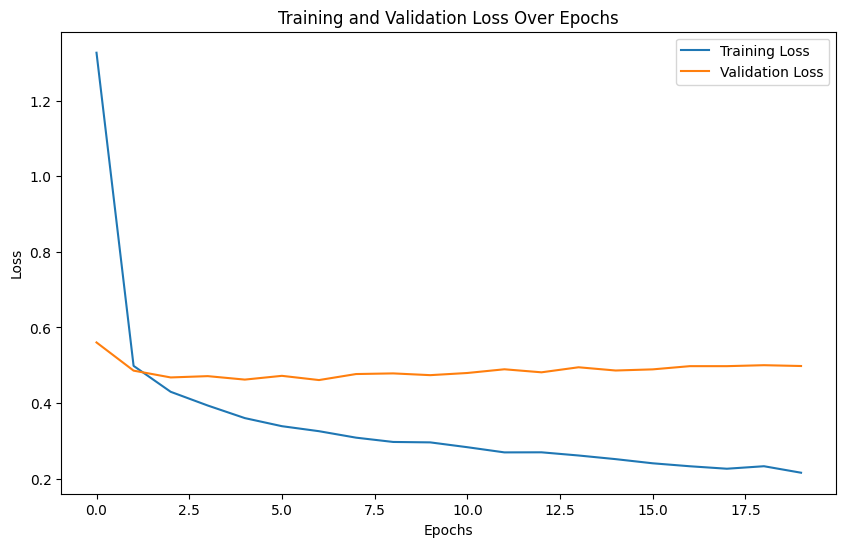

100%|██████████| 836/836 [00:50<00:00, 16.54it/s]

Test accuracy: 85.1675%
                                    precision    recall  f1-score   support

                     Affenpinscher       0.88      1.00      0.93         7
                      Afghan_hound       0.75      0.86      0.80         7
                  Airedale_terrier       1.00      1.00      1.00         6
                             Akita       1.00      1.00      1.00         8
                  Alaskan_malamute       1.00      0.91      0.95        11
               American_eskimo_dog       0.88      1.00      0.93         7
                 American_foxhound       0.86      1.00      0.92         6
    American_staffordshire_terrier       1.00      1.00      1.00         8
            American_water_spaniel       0.25      1.00      0.40         1
            Anatolian_shepherd_dog       1.00      0.67      0.80         9
             Australian_cattle_dog       0.89      0.89      0.89         9
               Australian_shepherd       0.89      1.00      0.

In [84]:
### SIMPLE PLUS Architecture
# Build the model
Xception_model_simple_plus = Sequential()
Xception_model_simple_plus.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
Xception_model_simple_plus.add(Dropout(0.5))
Xception_model_simple_plus.add(Dense(133, activation='softmax'))

# print summary of the model
Xception_model_simple_plus.summary()

# Compile the model
Xception_model_simple_plus.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# set epochs
epochs = 20

# add callbacks for model checkpointing 
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception_simple_plus.h5', 
                               verbose=1, save_best_only=True, monitor='val_loss')

# train the model and store the training history
history_simple_plus = Xception_model_simple_plus.fit(train_Xception, train_targets, 
                                    validation_data=(valid_Xception, valid_targets),
                                    epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=10)

plot_history_train(history_simple_plus)

# Load the model weights with the best validation loss.
history_simple_plus.load_weights('saved_models/weights.best.Xception_simple_plus.h5')

# Calculate classification accuracy on the test dataset.
Xception_predictions = list()

for feature in tqdm(test_Xception):
    with suppress_stdout_stderr():
        Xception_predictions.append(np.argmax(history_simple_plus.predict(np.expand_dims(feature, axis=0))))

# report test accuracy
test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

# print classification report
print(classification_report(np.array(Xception_predictions), np.argmax(test_targets, axis=1), target_names=dog_names))

### SIMPLE++ Architecture
Added another Dense Layer. Since just adding the dropout did neither improve accuracy, precision, recall or F1-score

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ global_average_pooling2d_22     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 133)            │        34,181 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 558,725 (2.13 MB)

 Trainable params: 558,725 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 4.75090, saving model to saved_models/weights.best.Xception_simple_pp.h5


Epoch 2/20

Epoch 2: val_loss improved from 4.75090 to 4.57439, saving model to saved_models/weights.best.Xception_simple_pp.h5


Epoch 3/20

Epoch 3: val_loss improved from 4.57439 to 4.41663, saving model to saved_models/weights.best.Xception_simple_pp.h5


Epoch 4/20

Epoch 4: val_loss improved from 4.41663 to 4.26738, saving model to saved_models/weights.best.Xception_simple_pp.h5


Epoch 5/20

Epoch 5: val_loss improved from 4.26738 to 4.13812, saving model to saved_models/weights.best.Xception_simple_pp.h5


Epoch 6/20

Epoch 6: val_loss improved from 4.13812 to 4.03138, saving model to saved_models/weights.best.Xception_simple_pp.h5


Epoch 7/20

Epoch 7: val_loss improved from 4.03138 to 3.93373, saving model to saved_models/weights.best.Xception_simple_pp.h5


Epoch 8/20

Epoch 8: val_loss improved from 3.93373 to 3.85276, saving model to saved_models/weights.best.Xception_simple_pp.h5


Epoch 9/20

Epoch 9: val_loss improved from 3.85276 to 3.78991, saving model to saved_models/weights.best.Xception_simple_pp.h5


Epoch 10/20

Epoch 10: val_loss improved from 3.78991 to 3.73147, saving model to saved_models/weights.best.Xception_simple_pp.h5


Epoch 11/20

Epoch 11: val_loss improved from 3.73147 to 3.67995, saving model to saved_models/weights.best.Xception_simple_pp.h5


Epoch 12/20

Epoch 12: val_loss improved from 3.67995 to 3.63366, saving model to saved_models/weights.best.Xception_simple_pp.h5


Epoch 13/20

Epoch 13: val_loss improved from 3.63366 to 3.59897, saving model to saved_models/weights.best.Xception_simple_pp.h5


Epoch 14/20

Epoch 14: val_loss improved from 3.59897 to 3.57042, saving model to saved_models/weights.best.Xception_simple_pp.h5


Epoch 15/20

Epoch 15: val_loss improved from 3.57042 to 3.53863, saving model to saved_models/weights.best.Xception_simple_pp.h5


Epoch 16/20

Epoch 16: val_loss improved from 3.53863 to 3.51777, saving model to saved_models/weights.best.Xception_simple_pp.h5


Epoch 17/20

Epoch 17: val_loss improved from 3.51777 to 3.48779, saving model to saved_models/weights.best.Xception_simple_pp.h5


Epoch 18/20

Epoch 18: val_loss improved from 3.48779 to 3.46946, saving model to saved_models/weights.best.Xception_simple_pp.h5


Epoch 19/20

Epoch 19: val_loss improved from 3.46946 to 3.46416, saving model to saved_models/weights.best.Xception_simple_pp.h5


Epoch 20/20

Epoch 20: val_loss improved from 3.46416 to 3.44537, saving model to saved_models/weights.best.Xception_simple_pp.h5


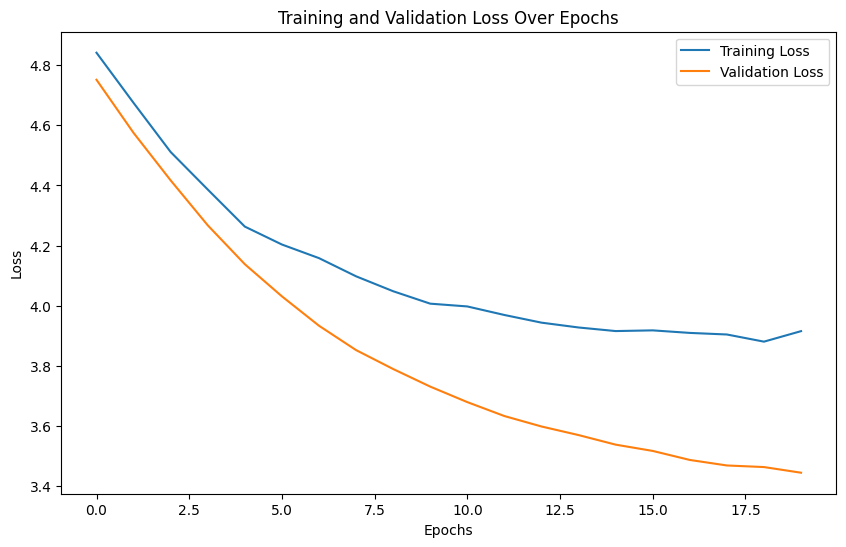

100%|██████████| 836/836 [00:55<00:00, 14.93it/s]

Test accuracy: 12.0813%
                                    precision    recall  f1-score   support

                     Affenpinscher       0.00      0.00      0.00         1
                      Afghan_hound       0.00      0.00      0.00         0
                  Airedale_terrier       0.00      0.00      0.00         0
                             Akita       0.25      0.67      0.36         3
                  Alaskan_malamute       0.90      0.43      0.58        21
               American_eskimo_dog       0.00      0.00      0.00         0
                 American_foxhound       0.00      0.00      0.00         0
    American_staffordshire_terrier       0.00      0.00      0.00         2
            American_water_spaniel       0.00      0.00      0.00         0
            Anatolian_shepherd_dog       0.17      1.00      0.29         1
             Australian_cattle_dog       0.11      0.06      0.07        18
               Australian_shepherd       0.00      0.00      0.


c:\Users\P334257\Documents\Udacity\04_Data_Science\05_Capstone\01_Dog_Breed_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P334257\Documents\Udacity\04_Data_Science\05_Capstone\01_Dog_Breed_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P334257\Documents\Udacity\04_Data_Science\05_Capstone\01_Dog_Breed_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no tr

In [93]:
### SIMPLE PLUS PLUS Architecture
# Build the model
Xception_model_simple_pp = Sequential()
Xception_model_simple_pp.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
Xception_model_simple_pp.add(Dense(256, activation='softmax'))
Xception_model_simple_pp.add(Dropout(0.5))
Xception_model_simple_pp.add(Dense(133, activation='softmax'))

# print summary of the model
Xception_model_simple_pp.summary()

# Compile the model
Xception_model_simple_pp.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# set epochs
epochs = 20

# add callbacks for model checkpointing 
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception_simple_pp.h5', 
                               verbose=1, save_best_only=True, monitor='val_loss')

# train the model and store the training history
history_simple_pp = Xception_model_simple_pp.fit(train_Xception, train_targets, 
                                    validation_data=(valid_Xception, valid_targets),
                                    epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=10)

plot_history_train(history_simple_pp)

# Load the model weights with the best validation loss.
Xception_model_simple_pp.load_weights('saved_models/weights.best.Xception_simple_pp.h5')

# Calculate classification accuracy on the test dataset.
Xception_predictions = list()

for feature in tqdm(test_Xception):
    with suppress_stdout_stderr():
        Xception_predictions.append(np.argmax(Xception_model_simple_pp.predict(np.expand_dims(feature, axis=0))))

# report test accuracy
test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

# print classification report
print(classification_report(np.array(Xception_predictions), np.argmax(test_targets, axis=1), target_names=dog_names))

### Tuning Parameters
since adding another dense layer made the classification way worse, espacially recall and F1-Score we go back to the SIMPLE+ Model and now tune parameters like "optimizer", "dropout-rate" and "batch-size". Usually you could perform a grid search here. But due to time and cpu constrains I tried the following ceteris paribus:

Optimizer:  adam <br>
Dropout:    to 0.7 <br>
Batch-Size: to 30 <br>



c:\Users\P334257\Documents\Udacity\04_Data_Science\05_Capstone\01_Dog_Breed_Classifier\.venv\Lib\site-packages\keras\src\layers\pooling\base_global_pooling.py:12: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ global_average_pooling2d_24     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 133)            │       272,517 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 272,517 (1.04 MB)

 Trainable params: 272,517 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.61596, saving model to saved_models/weights.best.Xception_simple_plus_t.h5


Epoch 2/20

Epoch 2: val_loss improved from 0.61596 to 0.51354, saving model to saved_models/weights.best.Xception_simple_plus_t.h5


Epoch 3/20

Epoch 3: val_loss improved from 0.51354 to 0.46501, saving model to saved_models/weights.best.Xception_simple_plus_t.h5


Epoch 4/20

Epoch 4: val_loss improved from 0.46501 to 0.46305, saving model to saved_models/weights.best.Xception_simple_plus_t.h5


Epoch 5/20

Epoch 5: val_loss improved from 0.46305 to 0.44871, saving model to saved_models/weights.best.Xception_simple_plus_t.h5


Epoch 6/20

Epoch 6: val_loss did not improve from 0.44871
Epoch 7/20

Epoch 7: val_loss improved from 0.44871 to 0.43437, saving model to saved_models/weights.best.Xception_simple_plus_t.h5


Epoch 8/20

Epoch 8: val_loss did not improve from 0.43437
Epoch 9/20

Epoch 9: val_loss did not improve from 0.43437
Epoch 10/20

Epoch 10: val_loss did not improve from 0.43437
Epoch 11/20

Epoch 11: val_loss did not improve from 0.43437
Epoch 12/20

Epoch 12: val_loss did not improve from 0.43437
Epoch 13/20

Epoch 13: val_loss did not improve from 0.43437
Epoch 14/20

Epoch 14: val_loss did not improve from 0.43437
Epoch 15/20

Epoch 15: val_loss did not improve from 0.43437
Epoch 16/20

Epoch 16: val_loss did not improve from 0.43437
Epoch 17/20

Epoch 17: val_loss did not improve from 0.43437
Epoch 18/20

Epoch 18: val_loss did not improve from 0.43437
Epoch 19/20

Epoch 19: val_loss did not improve from 0.43437
Epoch 20/20

Epoch 20: val_loss did not improve from 0.43437


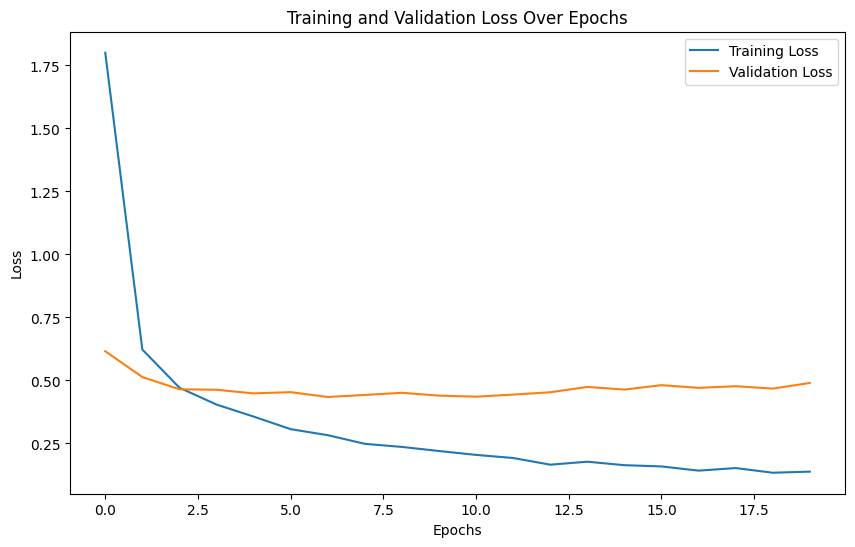

100%|██████████| 836/836 [00:53<00:00, 15.54it/s]

Test accuracy: 84.8086%
                                    precision    recall  f1-score   support

                     Affenpinscher       0.88      1.00      0.93         7
                      Afghan_hound       0.75      0.86      0.80         7
                  Airedale_terrier       1.00      1.00      1.00         6
                             Akita       1.00      1.00      1.00         8
                  Alaskan_malamute       1.00      0.91      0.95        11
               American_eskimo_dog       1.00      1.00      1.00         8
                 American_foxhound       0.86      1.00      0.92         6
    American_staffordshire_terrier       1.00      1.00      1.00         8
            American_water_spaniel       0.50      0.67      0.57         3
            Anatolian_shepherd_dog       1.00      0.75      0.86         8
             Australian_cattle_dog       1.00      0.90      0.95        10
               Australian_shepherd       1.00      0.90      0.

In [95]:
### SIMPLE PLUS Architecture
# Build the model
Xception_model_simple_plus_t = Sequential()
Xception_model_simple_plus_t.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
Xception_model_simple_plus_t.add(Dropout(0.7))
Xception_model_simple_plus_t.add(Dense(133, activation='softmax'))

# print summary of the model
Xception_model_simple_plus_t.summary()

# Compile the model
Xception_model_simple_plus_t.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# set epochs
epochs = 20

# add callbacks for model checkpointing 
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception_simple_plus_t.h5', 
                               verbose=1, save_best_only=True, monitor='val_loss')

# train the model and store the training history
history_simple_plus_t = Xception_model_simple_plus_t.fit(train_Xception, train_targets, 
                                    validation_data=(valid_Xception, valid_targets),
                                    epochs=epochs, batch_size=30, callbacks=[checkpointer], verbose=10)

plot_history_train(history_simple_plus_t)

# Load the model weights with the best validation loss.
Xception_model_simple_plus_t.load_weights('saved_models/weights.best.Xception_simple_plus_t.h5')

# Calculate classification accuracy on the test dataset.
Xception_predictions = list()

for feature in tqdm(test_Xception):
    with suppress_stdout_stderr():
        Xception_predictions.append(np.argmax(Xception_model_simple_plus_t.predict(np.expand_dims(feature, axis=0))))

# report test accuracy
test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

# print classification report
print(classification_report(np.array(Xception_predictions), np.argmax(test_targets, axis=1), target_names=dog_names))

In [109]:
report = classification_report(np.array(Xception_predictions), np.argmax(test_targets, axis=1), target_names=dog_names, output_dict=True)
print(report)


{'Affenpinscher': {'precision': 0.875, 'recall': 1.0, 'f1-score': 0.9333333333333333, 'support': 7.0}, 'Afghan_hound': {'precision': 0.75, 'recall': 0.8571428571428571, 'f1-score': 0.8, 'support': 7.0}, 'Airedale_terrier': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 6.0}, 'Akita': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 8.0}, 'Alaskan_malamute': {'precision': 1.0, 'recall': 0.9090909090909091, 'f1-score': 0.9523809523809523, 'support': 11.0}, 'American_eskimo_dog': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 8.0}, 'American_foxhound': {'precision': 0.8571428571428571, 'recall': 1.0, 'f1-score': 0.9230769230769231, 'support': 6.0}, 'American_staffordshire_terrier': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 8.0}, 'American_water_spaniel': {'precision': 0.5, 'recall': 0.6666666666666666, 'f1-score': 0.5714285714285714, 'support': 3.0}, 'Anatolian_shepherd_dog': {'precision': 1.0, 'recall': 0.75, 'f1-score': 0.85

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [96]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *

def Xception_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Xception_model_simple.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [97]:
# Test predict function
image_path = 'dogImages/test/032.Boston_terrier/Boston_terrier_02256.jpg'
print(Xception_predict_breed(image_path))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Boston_terrier


---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [98]:
from PIL import Image

def load_crop_img(path, w, h):
    im = Image.open(path)
    width, height = im.size   # Get dimensions

    left = (width - w)/2
    top = (height - h)/2
    right = (width + w)/2
    bottom = (height + h)/2

    # Crop the center of the image
    im = im.crop((left, top, right, bottom))
    print(im.size)
    return im

In [99]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg

def dog_breed_classifier(path: str):
    # run the detectors
    face = face_detector(path)
    dog = dog_detector(path)

    if face_detector(path):
        picture_type = 'human'
        breed = Xception_predict_breed(path)
    elif dog_detector(path):
        picture_type = 'dog'
        breed = Xception_predict_breed(path)
    else:
        picture_type = 'neither'

    if picture_type in (['dog', 'human']):
        print(f"Hello {picture_type}")
        
        image = Image.open(path)
        plt.imshow(image)
        plt.show()

        print("you look lik a ....\n")
        print(breed)
    else:
        print("ERROR: neither a human nor a dog were recognized")
        
        
        

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

In was quite suprised how well we could customize the last layers of a pretrained model using Transfer learning and the bottleneck features to accomplish a roughly 85% Accuracy with just 10 training epochs and just 6600 training images. 


Improving a pre-existing model like Xception can involve multiple strategies, particularly focusing on enhancing performance, reducing computational cost, or adapting the model to specific needs. Here are three possible improvements to consider:

**1. Data Augmentation:**<br>
*Description:* Implement advanced data augmentation techniques to artificially expand the dataset size and diversity.<br>
*Possible Techniques:* Include random rotations, translations, brightness adjustments, or image cropping. You can also apply more complex methods such as CutMix or MixUp.<br>
*Benefit:* Enhanced data diversity helps in reducing overfitting, allowing the model to generalize better across unseen data.<br>

**2. Hyperparameter Optimization e.g. using GridSearch:**
*Description:* Optimize hyperparameters such as learning rate, batch size, optimizer type, and dropout rates using techniques like grid search, random search, or Bayesian optimization.<br>
*Benefit:* Tailoring these parameters can significantly affect training dynamics and outcomes, potentially leading to more accurate and faster convergence.
Implementing these improvements could enhance the Xception model's efficacy when applied to specific tasks or datasets, helping to leverage its architectural strengths while addressing potential limitations.<br>

**3. Expand the Database for training**<br>
*Description:* Expand the Database of labeled dog pictures extensevly. Take care of still having a balanced and over the breeds evenly distributed dataset. Also the dataset can be expandend by real world images.  <br>
*Benefit:* With more images for training complexer models with more parameters can be build and trained. Also the diverser dataset can lead to a better capability of generalization<br>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Hello dog


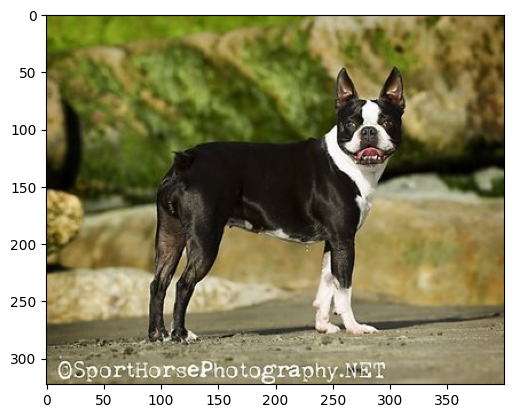

you look lik a ....

Boston_terrier


In [100]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
image_1 = 'lfw/Aaron_Eckhart/Aaron_Eckhart_0001.jpg'
image_2 = 'dogImages/test/032.Boston_terrier/Boston_terrier_02256.jpg'

dog_breed_classifier(image_2)
